# Global Optimization

The following global optimizers are implemented in Optiland:
1. Differential Evolution
2. Dual Annealing

These optimizers wrap the scipy.optimize implementations.

In [1]:
import numpy as np
from optiland import optic, optimization

Define a starting lens:

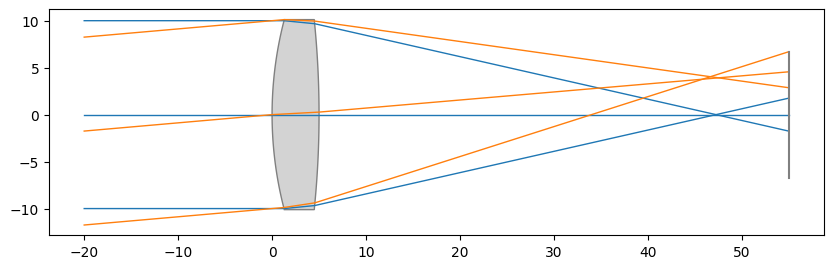

In [2]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=1, radius=40, thickness=5, material='SK16', is_stop=True)
lens.add_surface(index=2, radius=-100, thickness=50)
lens.add_surface(index=3)

# set aperture
lens.set_aperture(aperture_type='EPD', value=20)

# set fields
lens.set_field_type(field_type='angle')
lens.add_field(y=0)
lens.add_field(y=5)

# set wavelength
lens.add_wavelength(value=0.55, is_primary=True)

lens.draw()

Define optimization problem:

In [3]:
problem = optimization.OptimizationProblem()

Add operands (targets for optimization):

In [4]:
"""
Add a focal length operand and wavefront error operands for all fields.

Use Gaussian quadrature distribution for the rays (see distribution documentation for more information).
"""

# focal length target
input_data = {'optic': lens}
problem.add_operand(operand_type='f2', target=60, weight=1, input_data=input_data)

# wavefront error target
for field in lens.fields.get_field_coords():
    input_data = {'optic': lens, 'Hx':field[0], 'Hy': field[1], 'num_rays': 3, 'wavelength': 0.55, 'distribution': 'gaussian_quad'}
    problem.add_operand(operand_type='OPD_difference', target=0, weight=1, input_data=input_data)

Define variables - let both radii of curvature vary. We will use differential evolution, which requires bounds for all variables.

In [5]:
problem.add_variable(lens, 'radius', surface_number=1, min_val=-500, max_val=500)
problem.add_variable(lens, 'radius', surface_number=2, min_val=-500, max_val=500)

Let thicknesses to image plane vary:

In [6]:
problem.add_variable(lens, 'thickness', surface_number=2, min_val=30, max_val=100)

Check initial merit function value and system properties:

In [7]:
problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |                3716.81 |                 0 |
+----+------------------------+-------------------+
+----+----------------+----------+----------+---------+----------+--------------------+
|    | Operand Type   |   Target |   Weight |   Value |    Delta |   Contribution (%) |
|----+----------------+----------+----------+---------+----------+--------------------|
|  0 | f2             |       60 |        1 | 46.5275 | -13.4725 |            4.88345 |
|  1 | OPD difference |        0 |        1 | 56.0052 |  56.0052 |           84.3891  |
|  2 | OPD difference |        0 |        1 | 19.968  |  19.968  |           10.7275  |
+----+----------------+----------+----------+---------+----------+--------------------+
+----+-----------------+-----------+---------+--------------+--------------+
|    | Variable Type   |   Surface |   Value | 

Define optimizer:

In [8]:
optimizer = optimization.DifferentialEvolution(problem)

Run optimization:

In [9]:
optimizer.optimize(maxiter=256, disp=False, workers=-1)  # workers=-1 uses all available cores

             message: Optimization terminated successfully.
             success: True
                 fun: 3.290524752905151
                   x: [-5.678e-01 -3.674e+00  4.671e+00]
                 nit: 64
                nfev: 3097
          population: [[-5.678e-01 -3.674e+00  4.671e+00]
                       [-5.669e-01 -3.616e+00  4.663e+00]
                       ...
                       [-5.661e-01 -3.639e+00  4.681e+00]
                       [-5.689e-01 -3.738e+00  4.676e+00]]
 population_energies: [ 3.291e+00  3.310e+00 ...  3.326e+00  3.322e+00]
                 jac: [ 4.257e+02  1.385e+01  4.698e+01]

Print merit function value and system properties after optimization:

In [10]:
problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |                3.29053 |           99.9115 |
+----+------------------------+-------------------+
+----+----------------+----------+----------+----------+----------+--------------------+
|    | Operand Type   |   Target |   Weight |    Value |    Delta |   Contribution (%) |
|----+----------------+----------+----------+----------+----------+--------------------|
|  0 | f2             |       60 |        1 | 60.134   | 0.133985 |           0.545569 |
|  1 | OPD difference |        0 |        1 |  1.25245 | 1.25245  |          47.6713   |
|  2 | OPD difference |        0 |        1 |  1.30535 | 1.30535  |          51.7831   |
+----+----------------+----------+----------+----------+----------+--------------------+
+----+-----------------+-----------+-----------+--------------+--------------+
|    | Variable Type   |   Surface |  

Draw final lens:

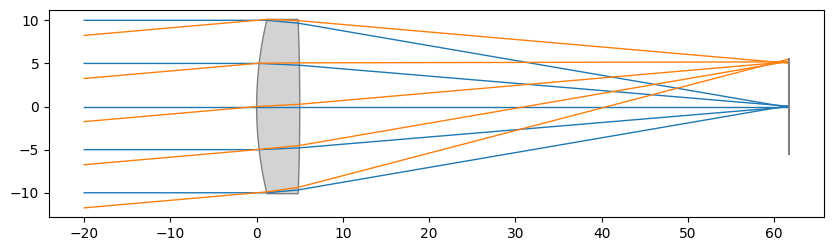

In [11]:
lens.draw(num_rays=5)